In [1]:
#Basic Functionalities:
import os
import pandas as pd
import numpy as np

#PyTorch
import torchvision
import torch
import timm
from torch import optim
from fastai.vision.learner import create_body
from torchvision.models import mobilenet_v2
from fastai.vision.models.unet import DynamicUnet
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
from torch import nn
from torchinfo import summary

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt

# Misc.
import PIL
import cv2
import sys
import time
import warnings
from skimage.color import rgb2lab, lab2rgb
from tqdm.notebook import tqdm_notebook
import random

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


In [2]:
class dataset(Dataset):
    
    def __init__(self, src: str):
        self.src = src
        self.image_paths = os.listdir(src)
        
        # Transformations for grayscale and other transformations
        #self.transforms = torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()
        self.transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                         torchvision.transforms.CenterCrop((224,224)),
                                                         torchvision.transforms.RandomHorizontalFlip()])
    
    def __len__(self):
        return len(self.image_paths)

    def apply_mosaic(self, image, top_left_x, top_left_y, width, height, mosaic_size):
        """
        Apply a mosaic effect to a specific area of the image.
        
        :param image: The original image.
        :param top_left_x: Top left x-coordinate of the mosaic area.
        :param top_left_y: Top left y-coordinate of the mosaic area.
        :param width: Width of the mosaic area.
        :param height: Height of the mosaic area.
        :param mosaic_size: Size of the mosaic blocks.
        """
        # Extract the region of interest
        roi = image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
        
        # Resize to mosaic size (downscale)
        roi_small = cv2.resize(roi, (mosaic_size, mosaic_size), interpolation=cv2.INTER_LINEAR)
        
        # Resize back to original size (upscale)
        mosaic = cv2.resize(roi_small, (width, height), interpolation=cv2.INTER_NEAREST)
        
        # Place the mosaic back into the original image
        image[top_left_y:top_left_y+height, top_left_x:top_left_x+width] = mosaic
        
        return image
                
    def __getitem__(self, index):
        img_path = os.path.join(self.src, self.image_paths[index])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        original = np.copy(img)

        img_height, img_width = img.shape[:2]
    
        # Define the size of the mosaic area
        mosaic_width = random.randint(50, 200)
        mosaic_height = random.randint(50, 200)
        mosaic_size = random.randint(5, 10)  # Size of each mosaic block
        
        # Randomly pick a spot
        top_left_x = random.randint(0, img_width - mosaic_width)
        top_left_y = random.randint(0, img_height - mosaic_height)
        
        # Apply the mosaic effect
        output_image = self.apply_mosaic(img, top_left_x, top_left_y, mosaic_width, mosaic_height, mosaic_size)

        # Convert images to tensors and permute dimensions
        original = torch.from_numpy(original.astype("float32")).permute(2, 0, 1)
        output_image = torch.from_numpy(output_image.astype("float32")).permute(2, 0, 1)
        
        return self.transforms(original)/255, self.transforms(output_image)/255


In [3]:
ds=dataset('./temp/food-101/images/tuna_tartare/')

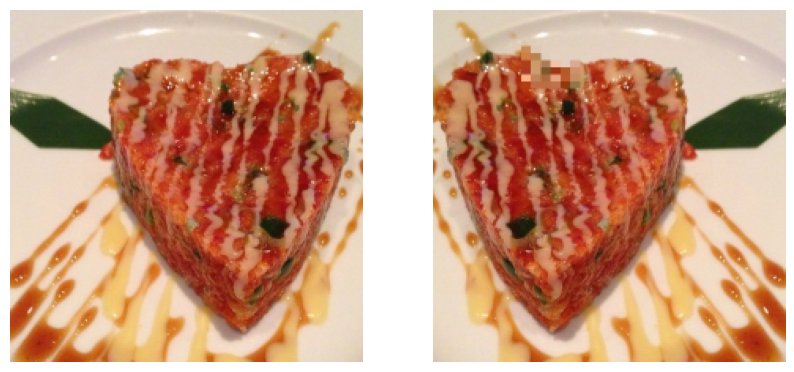

In [4]:
i=random.randint(0,1000)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(ds[i][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(ds[i][1].permute(1,2,0))

In [5]:
train_ds=dataset("./temp/food-101/images/tuna_tartare/")
test_ds=dataset("./temp/food-101/images/waffles/")

In [6]:
train_loader=torch.utils.data.DataLoader(train_ds,4)
test_loader=torch.utils.data.DataLoader(test_ds,4)

In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [9]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [10]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(build_mobile_unet(n_input=3, n_output=3, size=224), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.input = data[0].to(self.device)
        self.target = data[1].to(self.device)

    def forward(self):
        self.fake_correction = self.net_G(self.input)

    def backward_D(self):
        #fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_image = self.fake_correction
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        #real_image = torch.cat([self.L, self.ab], dim=1)
        real_image = self.target
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        #fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_image = self.fake_correction
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_correction, self.target) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [11]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)


def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [12]:
def train_model(model, train_dl, epochs, display_every=62):
    #data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm_notebook(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data[0].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses

#model = MainModel()
#train_model(model, train_dl, 100)

In [13]:
def build_mobile_unet(n_input=3, n_output=3, size=224):
    body = create_body(torchvision.models.mobilenet_v3_small(), n_in=n_input, pretrained=True, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size))
    return net_G

In [14]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for x,y in tqdm_notebook(train_dl):
            ip, target = x.to(device), y.to(device)

            #print(input.type())
            
            preds = net_G(ip)

            loss = criterion(preds, target)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), ip.size(0))

  
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")


net_G=build_mobile_unet().to(device)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_loader, opt, criterion, 20)

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
model = MainModel(net_G=net_G)
train_model(model, train_loader, 20)

model initialized with norm initialization


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 